# 1D convolution

Pytorch Conv1d is versatible. For convienence, I define a wrapper over Conv1d:

1. I assume **stride = 1** for Conv1D layer. 

2. Add padding so that input tensor and output tensors have the **same length**. Furthermore:
    * For causal convolution, I need to pad the data sequence on the left side
    * For non-causal convoltuion, I pad on both sizes of a data sequence
    
   Since stride = 1, the total padding size should be equal to dilation_s * (kernel_s - 1)

3. Pytorch conv1d operates along the last dimension a tensor. I need a **conv1d that operates along the second dimension of the inpute tensor (batchsize, length, dim)**;

4. Following the conventions in NSF models, I need to add **tanh()** right after conv1d;



In [4]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

class Conv1dKeepLength(torch_nn.Conv1d):
    """ Wrapper for causal convolution
    Input tensor:  (batchsize, length, dim_in)
    Output tensor: (batchsize, length, dim_out)
    
    Implemented based on:
    https://github.com/pytorch/pytorch/issues/1333
    
    Define:
        see __init__ below
        
    """
    def __init__(self, input_dim, output_dim, dilation_s, kernel_s, 
                 causal = False, stride = 1, groups=1, bias=True, \
                 tanh = True, pad_mode='constant'):
        super(Conv1dKeepLength, self).__init__(
            input_dim, output_dim, kernel_s, stride=1,
            padding = 0, dilation = dilation_s, groups=groups, bias=bias)

        self.pad_mode = pad_mode
        self.causal = causal
        
        # padding size
        # input & output length will be the same
        if self.causal:
            # left pad to make the convolution causal
            self.pad_le = dilation_s * (kernel_s - 1)
            self.pad_ri = 0
        else:
            # pad on both sizes
            self.pad_le = dilation_s * (kernel_s - 1) // 2
            self.pad_ri = dilation_s * (kernel_s - 1) - self.pad_le
    
        # activation functions
        if tanh:
            self.l_ac = torch_nn.Tanh()
        else:
            self.l_ac = torch_nn.Identity()
        
    def forward(self, data):
        # https://github.com/pytorch/pytorch/issues/1333
        # permute to (batchsize=1, dim, length)
        # add one dimension as (batchsize=1, dim, ADDED_DIM, length)
        # pad to ADDED_DIM
        # squeeze and return to (batchsize=1, dim, length+pad_length)
        x = torch_nn_func.pad(data.permute(0, 2, 1).unsqueeze(2), \
                              (self.pad_le, self.pad_ri,0,0), \
                              mode = self.pad_mode).squeeze(2)
        # tanh(conv1())
        # permmute back to (batchsize=1, length, dim)
        output = self.l_ac(super(Conv1dKeepLength, self).forward(x))
        return output.permute(0, 2, 1)

In [5]:
# Try one sample

# some configurations
batch_size = 3
frame_length = 10
input_feature_dim = 3
output_feature_dim = 4

with torch.no_grad():
    # create input data
    input_data = torch.rand(batch_size, frame_length, input_feature_dim)
    
    # create a conv1d layer (non-causal, dilation 1, kernel_s 2)
    l_conv1d = Conv1dKeepLength(input_feature_dim, output_feature_dim, dilation_s=1, kernel_s=2)
    
    # compute output data
    output_data = l_conv1d(input_data)


Input data shape: torch.Size([3, 10, 3])
Output data shape: torch.Size([3, 10, 4])


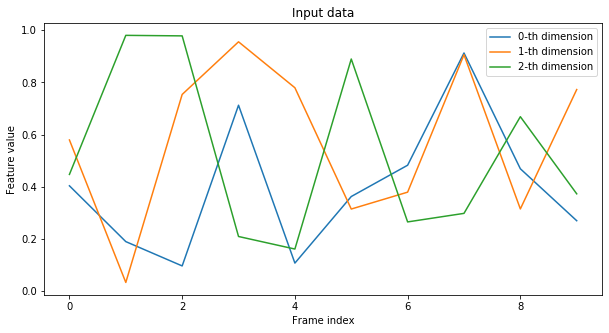

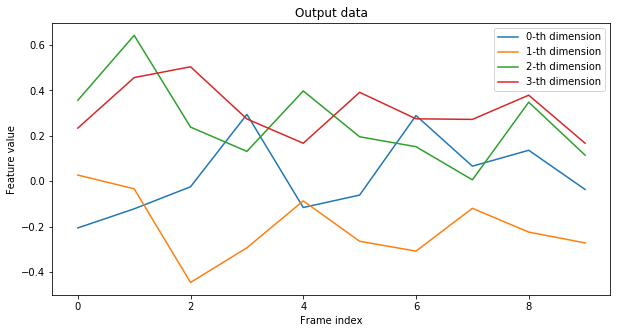

In [7]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

# plot input data (the 1st sequence in the batch)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(input_data[0, :, :]);
axis.set_xlabel('Frame index')
axis.set_ylabel('Feature value')
axis.legend([str(x) + '-th dimension' for x in range(input_feature_dim)])
axis.set_title('Input data')

# plot output data (the 1st sequence in the batch)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(output_data[0, :, :]);
axis.set_xlabel('Frame index')
axis.set_ylabel('Feature value')
axis.legend([str(x) + '-th dimension' for x in range(output_feature_dim)])
axis.set_title('Output data')

# print data shape
print("Input data shape: " + str(input_data.shape))
print("Output data shape: " + str(output_data.shape))

## Some explanation about padding

I used torch.nn.functional.pad to pad the data sequence. The Pytorch doc is not easy to understand, and I try to explain it here with examples

In [30]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# Let's try pad in different configurations
pad_size = 1
data = torch.sin(torch.rand(1, 4, 2)*2*np.pi)

def show_data(data, message):
    print(message)
    print("Shape:" + str(data.shape))
    print("Data:")
    print(data)
    print("\n")

# original data
show_data(data, '-- Original data -- ')

# try padding in different configs
data2 = torch_nn_func.pad(data, (0, pad_size))
show_data(data2, '-- append 1 dimension to each frame -- ')

data2 = torch_nn_func.pad(data, (pad_size, 0))
show_data(data2, '-- insert 1 dimension to the head of each frame -- ')

data2 = torch_nn_func.pad(data, (0, 0, 0, pad_size))
show_data(data2, '-- append 1 frame -- ')

data2 = torch_nn_func.pad(data, (0, 0, pad_size, 0))
show_data(data2, '-- insert 1 frame at the begining-- ')

data2 = torch_nn_func.pad(data, (0, pad_size, 0, 0))
show_data(data2, '-- append 1 dimension to each frame -- ')

data2 = torch_nn_func.pad(data, (pad_size, 0, 0, 0))
show_data(data2, '-- insert 1 dimension to the head of each frame -- ')

# Try the padding method used in Conv1DKeepLength
# 1. permute(0, 2, 1): transposes the data from (batchsize, length, dim) to (batchsize, dim, length)
# 2. pad: pad the tensor to (batchsize, dim, length + pad_length)
data2 = torch_nn_func.pad(data.permute(0, 2, 1), (pad_size, pad_size))
show_data(data2, '-- conv1d pad + dimension permute -- ')

# here is an equivalent way
data2 = torch_nn_func.pad(data.permute(0, 2, 1).unsqueeze(2), (pad_size, pad_size,0,0)).squeeze(2)
show_data(data2, '-- conv1d pad + dimension permute (equivalent way) -- ')

-- Original data -- 
Shape:torch.Size([1, 4, 2])
Data:
tensor([[[-0.7834,  0.9388],
         [-0.3026, -0.9638],
         [ 0.7852,  0.8871],
         [ 0.4327,  0.9741]]])


-- append 1 dimension to each frame -- 
Shape:torch.Size([1, 4, 3])
Data:
tensor([[[-0.7834,  0.9388,  0.0000],
         [-0.3026, -0.9638,  0.0000],
         [ 0.7852,  0.8871,  0.0000],
         [ 0.4327,  0.9741,  0.0000]]])


-- insert 1 dimension to the head of each frame -- 
Shape:torch.Size([1, 4, 3])
Data:
tensor([[[ 0.0000, -0.7834,  0.9388],
         [ 0.0000, -0.3026, -0.9638],
         [ 0.0000,  0.7852,  0.8871],
         [ 0.0000,  0.4327,  0.9741]]])


-- append 1 frame -- 
Shape:torch.Size([1, 5, 2])
Data:
tensor([[[-0.7834,  0.9388],
         [-0.3026, -0.9638],
         [ 0.7852,  0.8871],
         [ 0.4327,  0.9741],
         [ 0.0000,  0.0000]]])


-- insert 1 frame at the begining-- 
Shape:torch.Size([1, 5, 2])
Data:
tensor([[[ 0.0000,  0.0000],
         [-0.7834,  0.9388],
         [-0.3026, 

#### The end
We can define other modules based on conv1d, e.g., moving average, time-invairnt filtering.

Please check the following tutorial slides